In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from xgboost import XGBClassifier, callback, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
from tqdm import tqdm

In [65]:
tqdm.pandas()

file_path = './Heart+disease/Processed.cleveland.data'

df = pd.read_csv(file_path, header=None, encoding='latin1')

df.columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]

df.replace('?', np.nan, inplace=True)
df = df.dropna()
df = df.apply(pd.to_numeric)

df['target'] = df['num'].map(lambda x: 0 if x == 0 else 1)

X = df.drop(columns=['num', 'target'])
y = df['target']

from IPython.display import display
display(df.head(10))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3,1
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2,1
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1,1


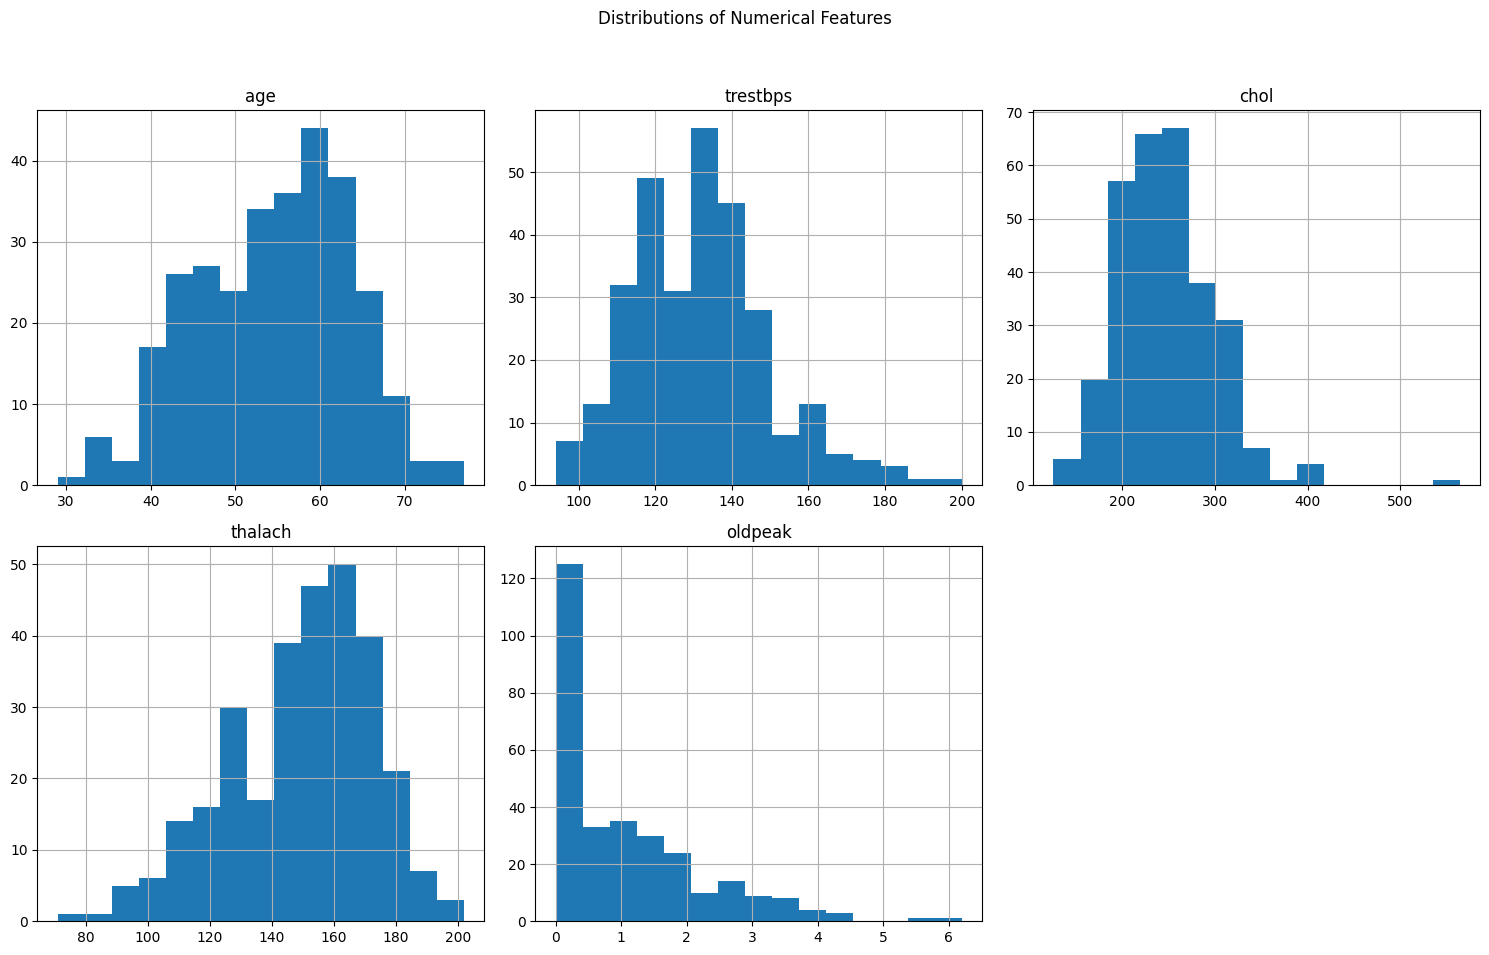

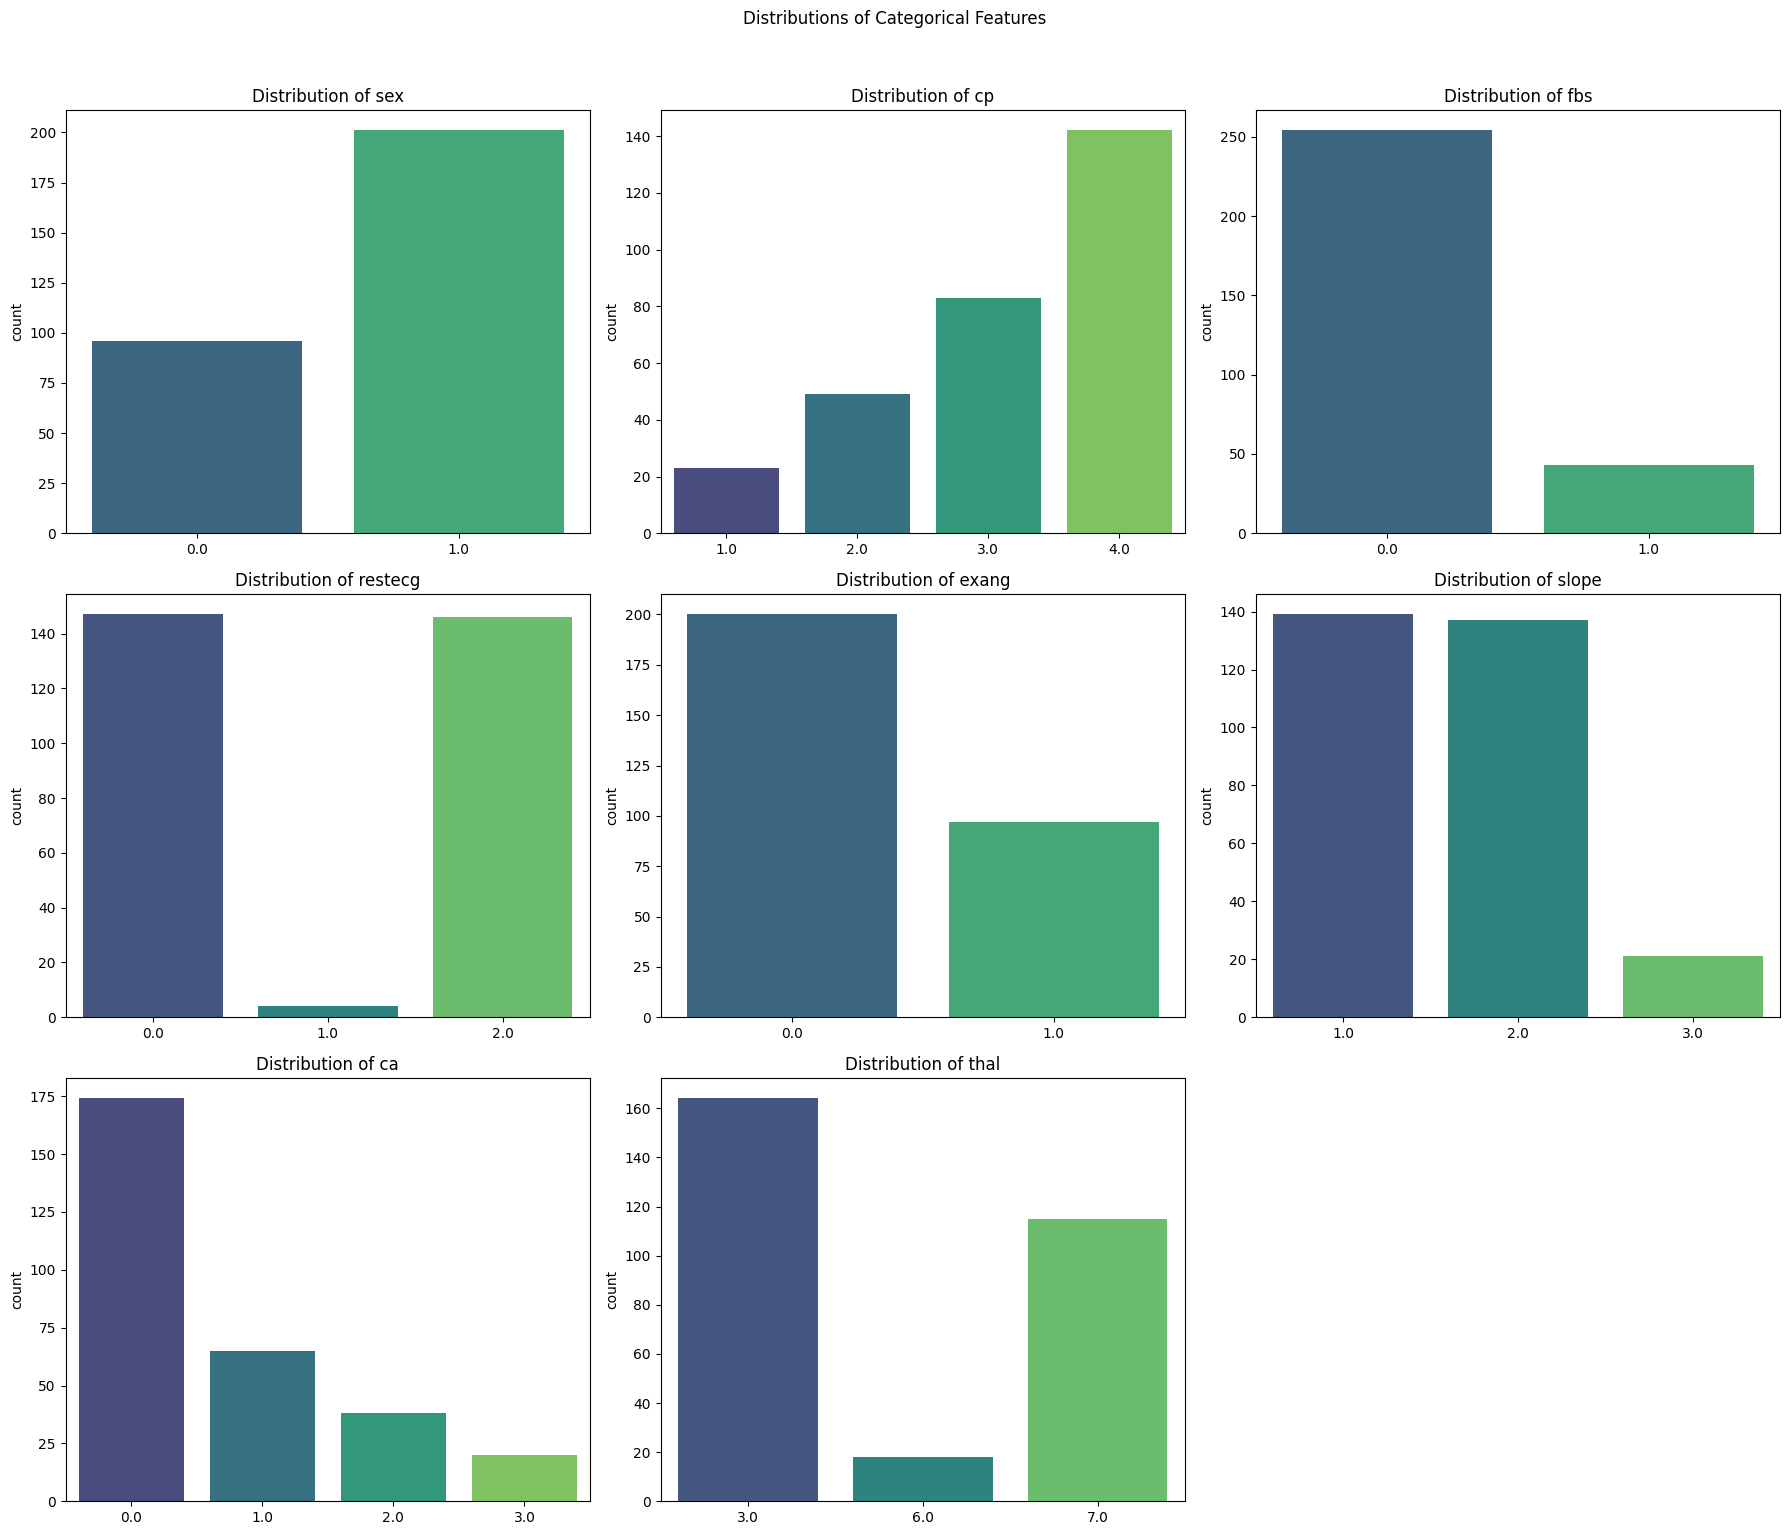

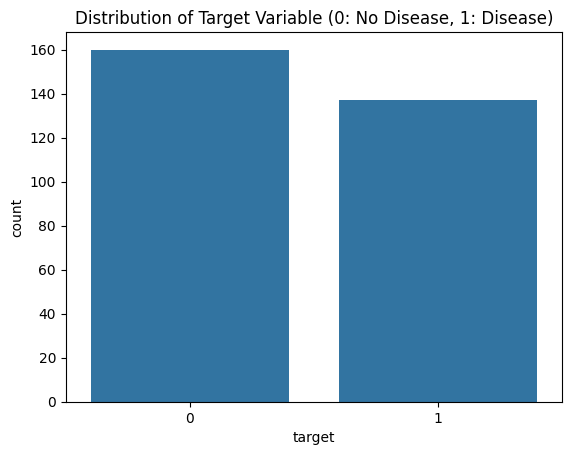

target
0    0.538721
1    0.461279
Name: proportion, dtype: float64


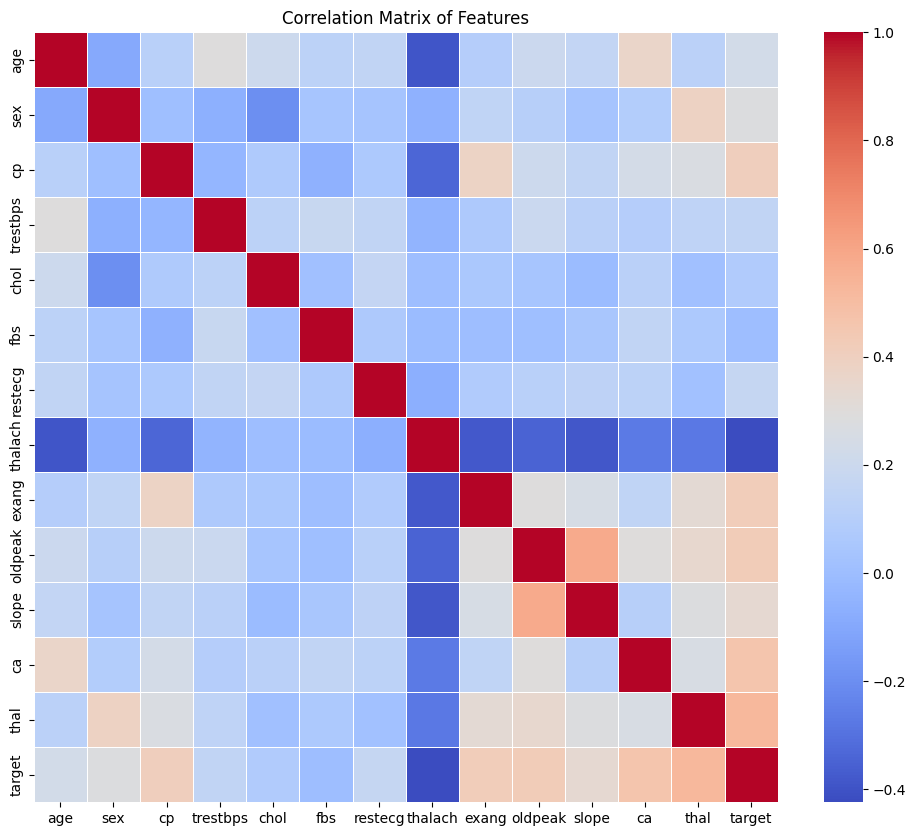

In [ ]:

df = df.drop(columns = ['num'])

numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df[numerical_features].hist(bins=15, figsize=(15, 10), layout=(2, 3))
plt.suptitle("Distributions of Numerical Features")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten() 

for i, col in enumerate(categorical_features):
    sns.countplot(x=df[col], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distributions of Categorical Features", y=1.02)
plt.tight_layout()
plt.show()

sns.countplot(x=df['target'])
plt.title('Distribution of Target Variable (0: No Disease, 1: Disease)')
plt.show()
print(df['target'].value_counts(normalize=True))

plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5) 
plt.title('Correlation Matrix of Features')
plt.show()



--- Basic Logistic Regression ---
Accuracy: 0.8333
              precision    recall  f1-score   support

           0      0.824     0.875     0.848        32
           1      0.846     0.786     0.815        28

    accuracy                          0.833        60
   macro avg      0.835     0.830     0.832        60
weighted avg      0.834     0.833     0.833        60



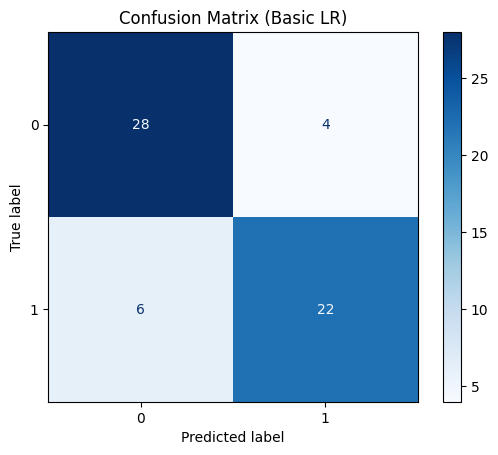


--- Basic Random Forest ---
Accuracy: 0.8500
              precision    recall  f1-score   support

           0      0.829     0.906     0.866        32
           1      0.880     0.786     0.830        28

    accuracy                          0.850        60
   macro avg      0.854     0.846     0.848        60
weighted avg      0.853     0.850     0.849        60



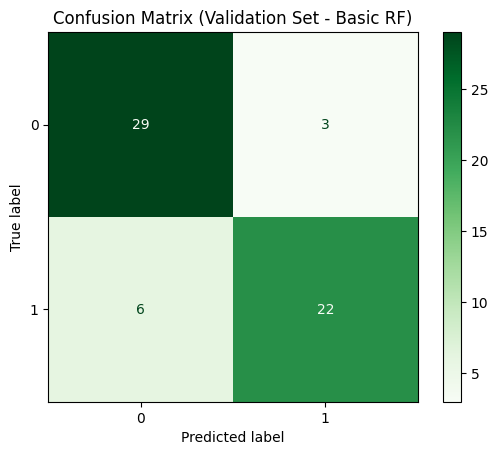


--- Basic XGBoost ---
Accuracy: 0.8667
              precision    recall  f1-score   support

           0      0.853     0.906     0.879        32
           1      0.885     0.821     0.852        28

    accuracy                          0.867        60
   macro avg      0.869     0.864     0.865        60
weighted avg      0.868     0.867     0.866        60



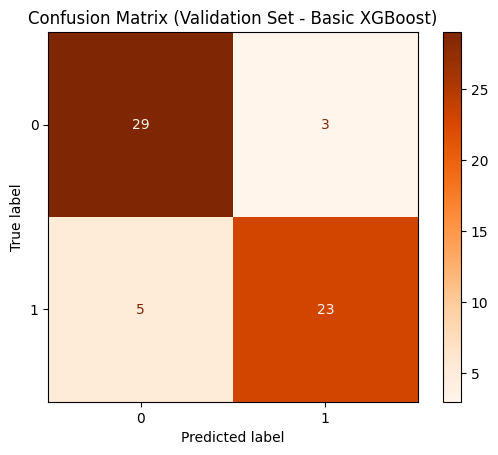

In [67]:

print("\n--- Basic Logistic Regression ---")
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(random_state=42, max_iter=1000)) 
])
pipeline_lr.fit(X_train, y_train)
y_pred_lr_basic = pipeline_lr.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, y_pred_lr_basic):.4f}")
print(classification_report(y_val, y_pred_lr_basic, digits=3))
ConfusionMatrixDisplay.from_estimator(pipeline_lr, X_val, y_val, cmap='Blues')
plt.title("Confusion Matrix (Basic LR)")
plt.show()

print("\n--- Basic Random Forest ---")
model = RandomForestClassifier(n_estimators=100, random_state=42) 
model.fit(X_train, y_train)
y_pred_rf_basic = model.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, y_pred_rf_basic):.4f}")
print(classification_report(y_val, y_pred_rf_basic, digits=3))
ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, cmap='Greens')
plt.title("Confusion Matrix (Validation Set - Basic RF)")
plt.show()

print("\n--- Basic XGBoost ---")
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)
y_pred_xgb_basic = model.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, y_pred_xgb_basic):.4f}")
print(classification_report(y_val, y_pred_xgb_basic, digits=3))
ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, cmap='Oranges')
plt.title("Confusion Matrix (Validation Set - Basic XGBoost)")
plt.show()



--- Tuning Random Forest ---
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Accuracy: 0.8333
              precision    recall  f1-score   support

           0      0.806     0.906     0.853        32
           1      0.875     0.750     0.808        28

    accuracy                          0.833        60
   macro avg      0.840     0.828     0.830        60
weighted avg      0.838     0.833     0.832        60



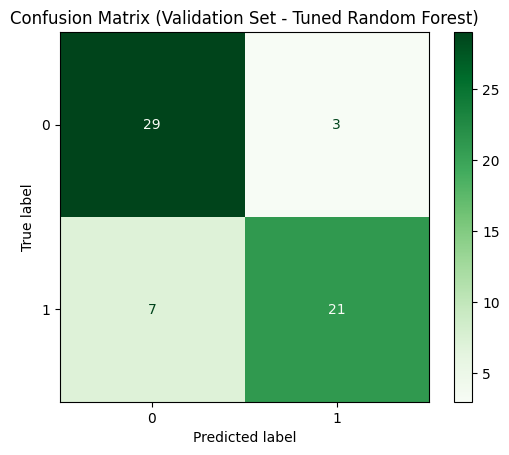

In [68]:

print("\n--- Tuning Random Forest ---")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

param = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'] 
}

model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred_rf = best_model.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print(classification_report(y_val, y_pred_rf, digits=3))
ConfusionMatrixDisplay.from_estimator(best_model, X_val, y_val, cmap='Greens')
plt.title("Confusion Matrix (Validation Set - Tuned Random Forest)")
plt.show()



--- Tuned XGBoost ---
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Accuracy: 0.8667
              precision    recall  f1-score   support

           0      0.853     0.906     0.879        32
           1      0.885     0.821     0.852        28

    accuracy                          0.867        60
   macro avg      0.869     0.864     0.865        60
weighted avg      0.868     0.867     0.866        60



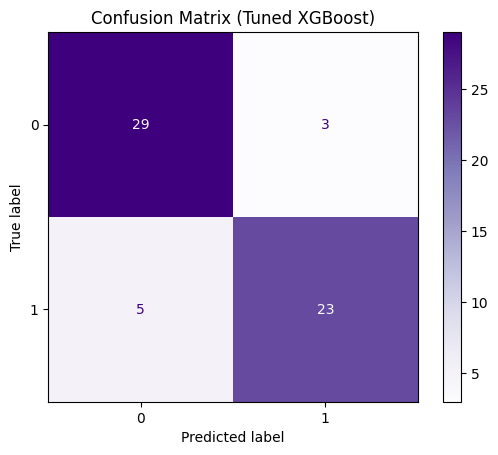

In [69]:

print("\n--- Tuned XGBoost ---")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 0.1]
}

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred_xgb = best_model.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, y_pred_xgb):.4f}")
print(classification_report(y_val, y_pred_xgb, digits=3))
ConfusionMatrixDisplay.from_estimator(best_model, X_val, y_val, cmap='Purples')
plt.title("Confusion Matrix (Tuned XGBoost)")
plt.show()

In [70]:

print("\n--- Final Model Performance Summary (Validation Set Accuracy) ---")
print(f"Basic Logistic Regression: {accuracy_score(y_val, y_pred_lr_basic):.4f}")
print(f"Basic Random Forest:       {accuracy_score(y_val, y_pred_rf_basic):.4f}")
print(f"Basic XGBoost:             {accuracy_score(y_val, y_pred_xgb_basic):.4f}")
print(f"Tuned XGBoost:             {accuracy_score(y_val, y_pred_xgb):.4f}")
print(f"Tuned Random Forest:       {accuracy_score(y_val, y_pred_rf):.4f}")


--- Final Model Performance Summary (Validation Set Accuracy) ---
Basic Logistic Regression: 0.8333
Basic Random Forest:       0.8500
Basic XGBoost:             0.8667
Tuned XGBoost:             0.8667
Tuned Random Forest:       0.8333


In [ ]:

print("\n--- Misclassified Samples (Validation Set) ---")

y_pred = y_pred_xgb

misclassified_indices = y_val.index[y_pred != y_val]

misclassified_samples = X_val.loc[misclassified_indices]
misclassified_true_labels = y_val.loc[misclassified_indices]
misclassified_predictions = pd.Series(y_pred[y_pred != y_val], index=misclassified_indices)

misclassified_df = pd.concat([
    misclassified_samples,
    misclassified_true_labels.rename('True Label'),
    misclassified_predictions.rename('Predicted Label')
], axis=1)

if misclassified_df.empty:
    print("No misclassified samples found")
else:
    print(f"Number of misclassified samples: {len(misclassified_df)}")
    from IPython.display import display
    display(misclassified_df)




--- Misclassified Samples (Validation Set) ---
Number of misclassified samples: 8


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,True Label,Predicted Label
102,57.0,0.0,4.0,128.0,303.0,0.0,2.0,159.0,0.0,0.0,1.0,1.0,3.0,0,1
33,59.0,1.0,4.0,135.0,234.0,0.0,0.0,161.0,0.0,0.5,2.0,0.0,7.0,0,1
245,67.0,1.0,4.0,120.0,237.0,0.0,0.0,71.0,0.0,1.0,2.0,0.0,3.0,1,0
278,57.0,1.0,2.0,154.0,232.0,0.0,2.0,164.0,0.0,0.0,1.0,1.0,3.0,1,0
232,49.0,1.0,3.0,118.0,149.0,0.0,2.0,126.0,0.0,0.8,1.0,3.0,3.0,1,0
187,66.0,1.0,2.0,160.0,246.0,0.0,0.0,120.0,1.0,0.0,2.0,3.0,6.0,1,0
290,67.0,1.0,3.0,152.0,212.0,0.0,2.0,150.0,0.0,0.8,2.0,0.0,7.0,1,0
183,59.0,1.0,1.0,178.0,270.0,0.0,2.0,145.0,0.0,4.2,3.0,0.0,7.0,0,1
